In [33]:
import open3d as o3d
import numpy as np
import random
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from sklearn.manifold import MDS
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import os

from f_extract_buried_points import extract_buried_points
from f_extract_surface_patch import *
from f_visualize_pointcloud import visualize_pointcloud
from f_create_ang_rad_bins import create_ang_rad_bins
from f_helper_functions import *
from f_compare_patches import *
from f_center_embedding import center_embedding

### Import the data generated by MaSIF-site

In [34]:
# Import the coordinates and the features that have been generated by dMaSIF-site of the following proteins
#   - Subunit A (IgG Fc)
#   - Subunit C (GB1 protein)
#   - Complex (Subunit A and C combined)

os.chdir('c:\\Users\\david\\MT_code\\masif_site_outputs\\1fcc')

coords_A = np.load("1fcc_A_predcoords.npy")
features_A = np.load("1fcc_A_predfeatures_emb1.npy")
features_A = features_A[:, 16:32]

coords_C = np.load("1fcc_C_predcoords.npy")
features_C = np.load("1fcc_C_predfeatures_emb1.npy")
features_C = features_C[:, 16:32]

coords_complex = np.load("1fcc_A, C_predcoords.npy")
features_complex = np.load("1fcc_A, C_predfeatures_emb1.npy")

In [35]:
# Normalize features
features_A = normalize_m11(features_A)
features_C = normalize_m11(features_C)

### Compute Buried Surface of Both Proteins

In [36]:
buried_A, buried_A_center = extract_buried_points(coords_A, coords_complex, 2)
buried_C, buried_C_center = extract_buried_points(coords_C, coords_complex, 2)
print(buried_A_center, buried_C_center)

#os.chdir('c:\\Users\\david\\MT_code\\extracted_patches')
#np.save("buried_A_coords.npy", buried_A)
#np.save("buried_C_coords.npy", buried_C)

4419 6820


### Select Center for Patch Extraction

In [37]:
center_A = 4419 #buried_A_center
center_C =  6820 #random.randint(0, len(coords_C))
print(center_A, center_C)

4419 6820


### Visualize the buried points on the protein surface

In [38]:
blue = [0, 0.5, 1]
red = [1, 0, 0]
green = [0, 1, 0]
yellow = [1, 1, 0]
black = [0, 0, 0]
pink = [1, 0, 1]

colors_A = np.zeros_like(coords_A)
colors_A[:] = blue
#colors_A[buried_A] = red
colors_A[center_A] = green

#visualize_pointcloud(coords_A, colors = colors_A)

colors_C = np.zeros_like(coords_C)
colors_C[:] = blue
#colors_C[buried_C] = red
colors_C[center_C] = green

#visualize_pointcloud(coords_C, colors = colors_C)

### Extract a patch of fixed geodesic radius from the center of the buried surfaces of both proteins

In [39]:
#patch_indeces, patch_coords, pairwise_distances = extract_surface_patch(coords_A, center_A, 12)
#patch_A = {}
#patch_A["indeces"] = patch_indeces
#patch_A["coords"] = patch_coords
#patch_A["distance_matrix"] = pairwise_distances
#patch_A["features"]=features_A[patch_A["indeces"]]

In [40]:
#patch_indeces, patch_coords, pairwise_distances = extract_surface_patch(coords_C, center_C, 12)
#patch_C = {}
#patch_C["indeces"] = patch_indeces
#patch_C["coords"] = patch_coords
#patch_C["coords"] = patch_coords
#patch_C["distance_matrix"] = pairwise_distances
#patch_C["features"]=features_C[patch_C["indeces"]]

### Save extracted patches

In [41]:
os.chdir('c:\\Users\\david\\MT_code\\extracted_patches\\from_patch')
#np.save('chain_A_patch_' + str(center_A) + '.npy', patch_A)
#np.save('chain_C_patch_' + str(center_C) + '_16.npy', patch_C)

### Import extracted patches

In [42]:
os.chdir('c:\\Users\\david\\MT_code\\extracted_patches\\chain_A')
patch_A = np.load('chain_A_patch_' + str(center_A) + '.npy', allow_pickle="TRUE").item()

os.chdir('c:\\Users\\david\\MT_code\\extracted_patches\\chain_C')
patch_C = np.load('chain_C_patch_' + str(center_C) + '.npy', allow_pickle="TRUE").item()

### Visualize the extracted patch on the protein surface

In [43]:
colors_A[patch_A["indeces"]]= green
#visualize_pointcloud(coords_A, colors = colors_A)

colors_C[patch_C["indeces"]]= green
visualize_pointcloud(coords_C, colors = colors_C)

### Visualize the patch within the points of first_sel and second_sel

In [44]:
#colors_A_test = np.zeros_like(coords_A[patch_A["first_sel"]])
#colors_A_test[:] = blue
#to_make_red = patch_A["indeces"]
#for ind, member in enumerate(patch_A["first_sel"]):
#    if member in to_make_red:
#        colors_A_test[ind]=red
#
#visualize_pointcloud(coords_A[patch_A["first_sel"]], colors = colors_A_test)


In [45]:
#colors_A_test = np.zeros_like(coords_A[patch_A["second_sel"]])
#colors_A_test[:] = blue
#to_make_red = patch_A["indeces"]
#for ind, member in enumerate(patch_A["second_sel"]):
#    if member in to_make_red:
#        colors_A_test[ind]=red
#
#visualize_pointcloud(coords_A[patch_A["second_sel"]], colors = colors_A_test)


In [46]:
#colors_C_test = np.zeros_like(coords_C[patch_C["first_sel"]])
#colors_C_test[:] = blue
#to_make_red = patch_C["indeces"]
#for ind, member in enumerate(patch_C["first_sel"]):
#    if member in to_make_red:
#        colors_C_test[ind]=red

#visualize_pointcloud(coords_C[patch_C["first_sel"]], colors = colors_C_test)


In [47]:
#colors_C_test = np.zeros_like(coords_C[patch_C["second_sel"]])
#colors_C_test[:] = blue
#to_make_red = patch_C["indeces"]
#for ind, member in enumerate(patch_C["second_sel"]):
#    if member in to_make_red:
#        colors_C_test[ind]=red

#visualize_pointcloud(coords_C[patch_C["second_sel"]], colors = colors_C_test)


### Visualize pointcloud in rainbow colors

In [48]:
## Assign colors

knn = NearestNeighbors(n_neighbors=int(len(patch_A["coords"])/12))
knn.fit(patch_A["coords"])
neighbors1 = knn.kneighbors([coords_A[center_A]], return_distance=False)

knn = NearestNeighbors(n_neighbors=int(len(patch_A["coords"])/7))
knn.fit(patch_A["coords"])
neighbors2 = knn.kneighbors([coords_A[center_A]], return_distance=False)

knn = NearestNeighbors(n_neighbors=int(len(patch_A["coords"])/4))
knn.fit(patch_A["coords"])
neighbors3 = knn.kneighbors([coords_A[center_A]], return_distance=False)

knn = NearestNeighbors(n_neighbors=int(len(patch_A["coords"])/2))
knn.fit(patch_A["coords"])
neighbors4 = knn.kneighbors([coords_A[center_A]], return_distance=False)

knn = NearestNeighbors(n_neighbors=int(len(patch_A["coords"])/1.1))
knn.fit(patch_A["coords"])
neighbors5 = knn.kneighbors([coords_A[center_A]], return_distance=False)


In [49]:
colors_A_rainbow = np.zeros_like(patch_A["coords"])
colors_A_rainbow[:] = blue

colors_A_rainbow[neighbors5]=red
colors_A_rainbow[neighbors4]=green
colors_A_rainbow[neighbors3]=blue
colors_A_rainbow[neighbors2]=pink
colors_A_rainbow[neighbors1]=yellow

visualize_pointcloud(patch_A["coords"], colors = colors_A_rainbow)


In [50]:
## Assign colors

knn = NearestNeighbors(n_neighbors=int(len(patch_C["coords"])/12))
knn.fit(patch_C["coords"])
neighbors1 = knn.kneighbors([coords_C[center_C]], return_distance=False)

knn = NearestNeighbors(n_neighbors=int(len(patch_C["coords"])/7))
knn.fit(patch_C["coords"])
neighbors2 = knn.kneighbors([coords_C[center_C]], return_distance=False)

knn = NearestNeighbors(n_neighbors=int(len(patch_C["coords"])/4))
knn.fit(patch_C["coords"])
neighbors3 = knn.kneighbors([coords_C[center_C]], return_distance=False)

knn = NearestNeighbors(n_neighbors=int(len(patch_C["coords"])/2))
knn.fit(patch_C["coords"])
neighbors4 = knn.kneighbors([coords_C[center_C]], return_distance=False)

knn = NearestNeighbors(n_neighbors=int(len(patch_C["coords"])/1.1))
knn.fit(patch_C["coords"])
neighbors5 = knn.kneighbors([coords_C[center_C]], return_distance=False)

In [51]:
colors_C_rainbow = np.zeros_like(patch_C["coords"])
colors_C_rainbow[:] = blue

colors_C_rainbow[neighbors5]=red
colors_C_rainbow[neighbors4]=green
colors_C_rainbow[neighbors3]=blue
colors_C_rainbow[neighbors2]=pink
colors_C_rainbow[neighbors1]=yellow

visualize_pointcloud(patch_C["coords"], colors = colors_C_rainbow)

### Embedding in 2D with MDS

In [52]:
#Using the Geodesic Distances

mds = MDS(dissimilarity='precomputed', random_state=0)
# Get the embeddings
embedding_A = mds.fit_transform(patch_A["distance_matrix"])
embedding_C = mds.fit_transform(patch_C["distance_matrix"])

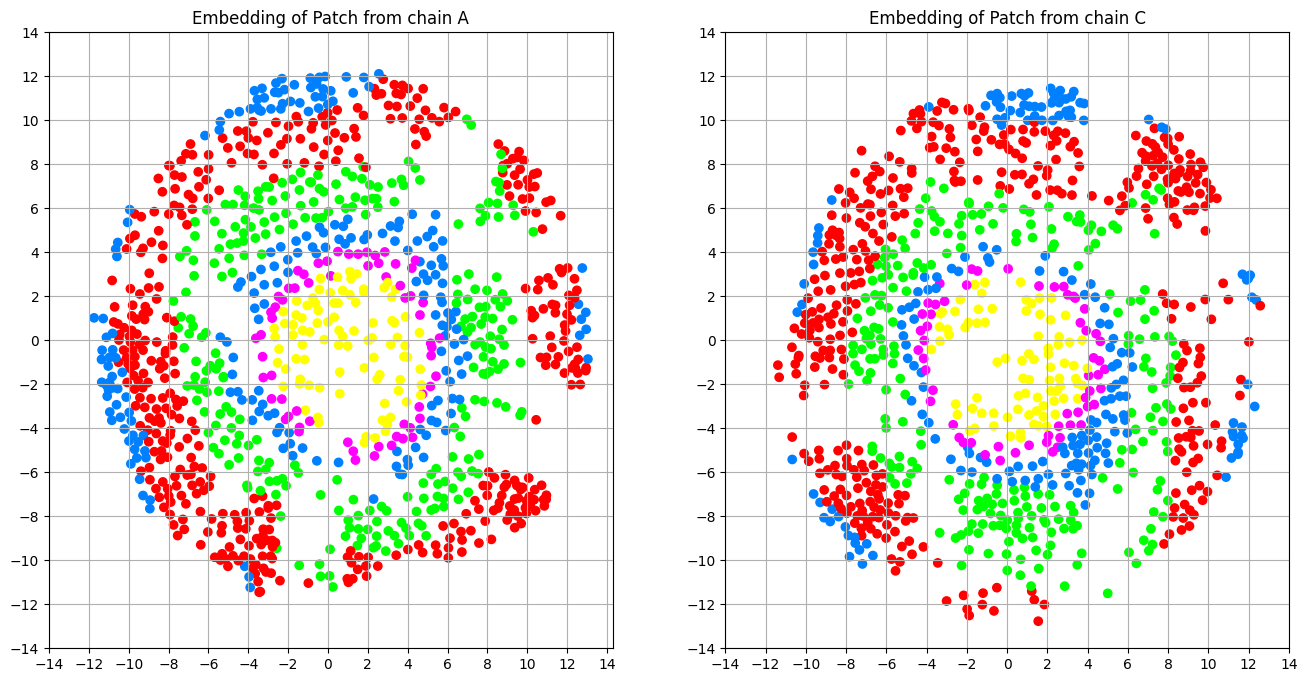

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

ax1 = plt.subplot(1,2,1)
ax1.scatter(embedding_A[:,0], embedding_A[:,1], c = colors_A_rainbow)
ax1.set_title("Embedding of Patch from chain A")
ax1.grid(axis = "x")
ax1.grid(axis = "y")
ax1.xaxis.set_ticks(np.arange(-14, 16, 2))
ax1.yaxis.set_ticks(np.arange(-14, 16, 2))


ax2 = plt.subplot(1,2,2)

ax2.scatter(embedding_C[:,0], embedding_C[:,1], c = colors_C_rainbow)
ax2.set_title("Embedding of Patch from chain C")
ax2.grid(axis = "x")
ax2.grid(axis = "y")
ax2.xaxis.set_ticks(np.arange(-14, 16, 2))
ax2.yaxis.set_ticks(np.arange(-14, 16, 2))


### Center Embeddings around the origin

In [54]:
embedding_A = center_embedding(embedding_A)
embedding_C = center_embedding(embedding_C)

### Save the features of the two patches in arrays

In [55]:
features_patch_A = patch_A["features"]
features_patch_C = patch_C["features"]

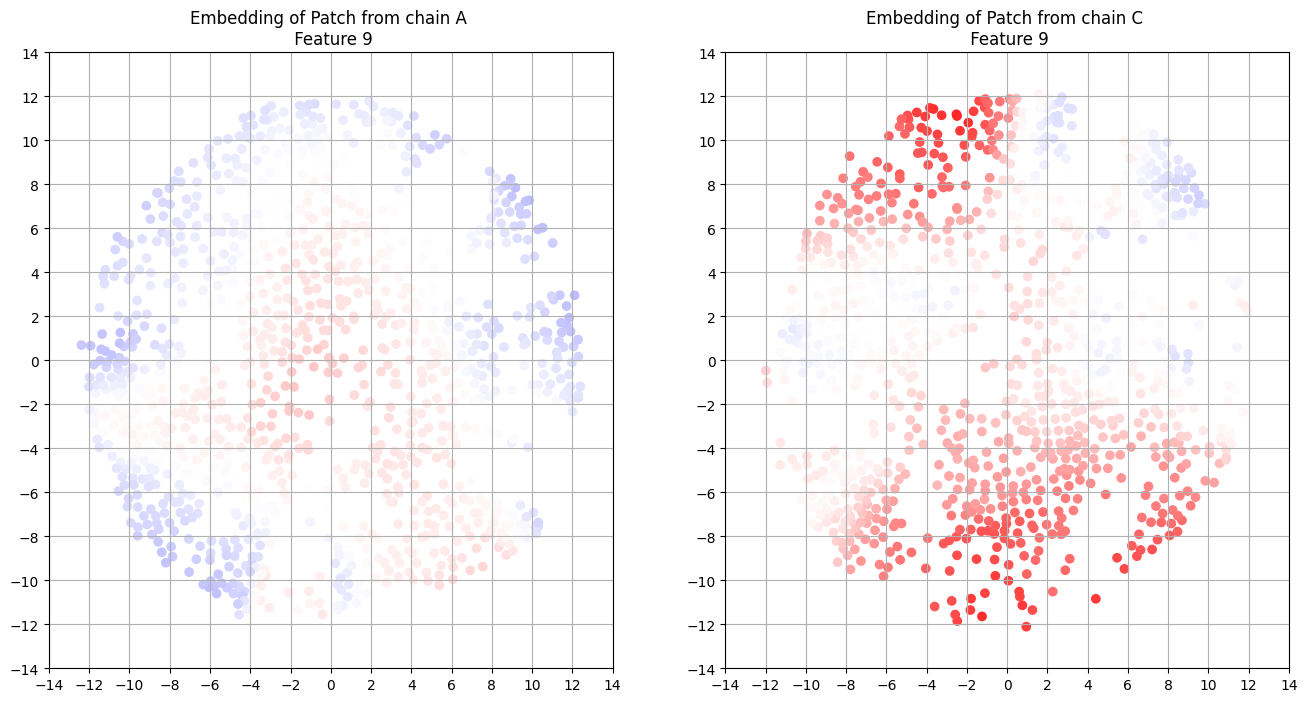

In [56]:
feature = 9

normalize_col_features = colors.Normalize(vmin=-1, vmax=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

ax1 = plt.subplot(1,2,1)
ax1.scatter(embedding_A[:,0], embedding_A[:,1], c = features_patch_A[:,feature], cmap = "bwr", norm=normalize_col_features)
ax1.set_title("Embedding of Patch from chain A \n Feature {feature}".format(feature=feature))
ax1.grid(axis = "x")
ax1.grid(axis = "y")
ax1.xaxis.set_ticks(np.arange(-14, 16, 2))
ax1.yaxis.set_ticks(np.arange(-14, 16, 2))


ax2 = plt.subplot(1,2,2)

ax2.scatter(embedding_C[:,0], embedding_C[:,1], c = features_patch_C[:,feature], cmap = "bwr", norm=normalize_col_features)
ax2.set_title("Embedding of Patch from chain C \n Feature {feature}".format(feature=feature))
ax2.grid(axis = "x")
ax2.grid(axis = "y")
ax2.xaxis.set_ticks(np.arange(-14, 16, 2))
ax2.yaxis.set_ticks(np.arange(-14, 16, 2))


### Convert to Polar Coordinates

In [57]:
polar_coords_A = cart_to_polar(embedding_A)
polar_coords_C = cart_to_polar(embedding_C)

Text(0.5, 1.0, 'Embedding of Patch from chain C in polar coordinates')

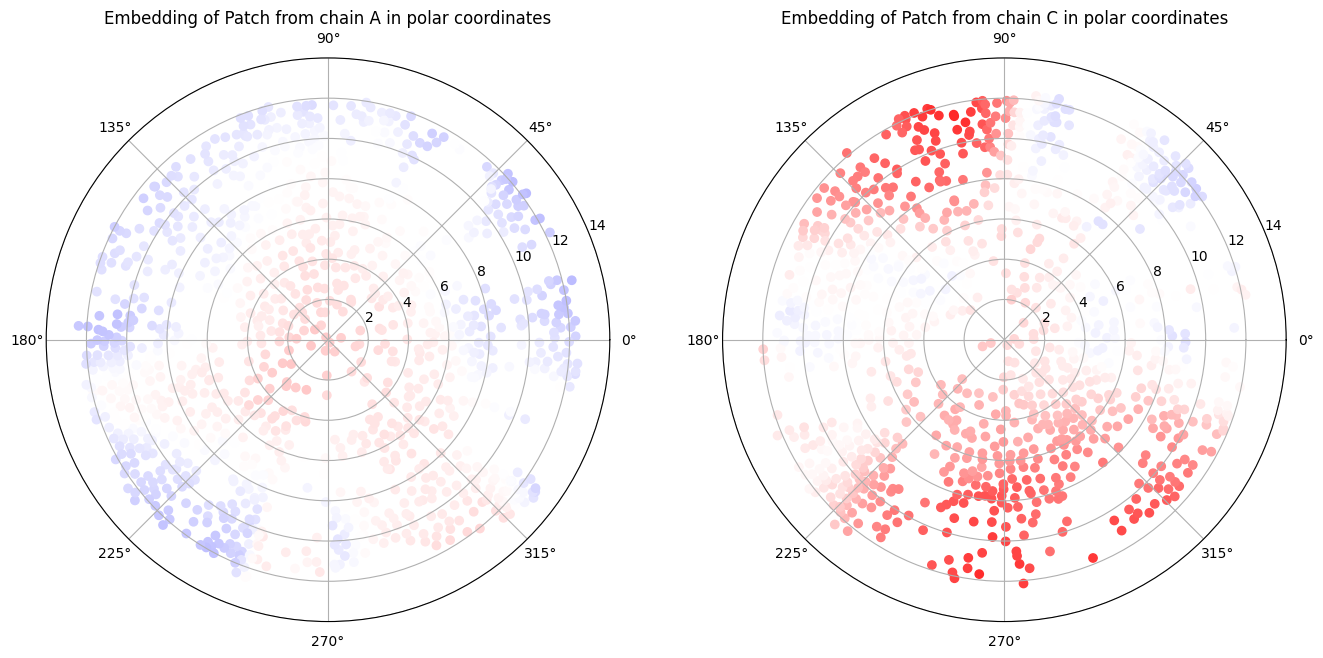

In [58]:
fig = plt.figure(figsize=(16,8))
A = fig.add_subplot(121, projection='polar')
plot1 = A.scatter(polar_coords_A[:,1], polar_coords_A[:,0], c = features_patch_A[:,feature], cmap = "bwr", norm=normalize_col_features)
A.set_ylim([0, 14])
plt.title("Embedding of Patch from chain A in polar coordinates")

C= fig.add_subplot(122, projection='polar')
plot2 = C.scatter(polar_coords_C[:,1], polar_coords_C[:,0], c = features_patch_C[:,feature], cmap = "bwr", norm=normalize_col_features)
C.set_ylim([0, 14])
plt.title("Embedding of Patch from chain C in polar coordinates")

### Translate the Embedding into radial and angular bins to create array of fixed dimension

In [59]:
# Set the number of radial and angular bins and how many of its nearest neighbors should be taken into 
# account for the calculation of each bins feature vector

max_rho = 12 # diameter of the patches

n_angular_bins = 72
n_radial_bins = 10
n_neighbors = 8

# Create meshgrid n_angular_bins x n_radial_bins (+1 to have the right numb or spaces in between)
angular, radial = np.mgrid[-np.pi:np.pi:complex(n_angular_bins+1), 0:max_rho:complex(n_radial_bins+1)]

# To create a feature vector (length 16) for each of the bins and save them in a np.array of shape (angular bins x radial bins x features)
# Feed the meshgrid matrices, the features matrices, the cartesian coords and a number of nearest neighbors (for the bin feature computation)
tensor_A = create_ang_rad_bins(angular, radial, features_patch_A, embedding_A, n_neighbors) 
tensor_C = create_ang_rad_bins(angular, radial, features_patch_C, embedding_C, n_neighbors)

C:\Users\david\AppData\Local\Temp\ipykernel_8048\2078384961.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax1.pcolormesh(angular, radial, col_A, cmap = "bwr", norm=normalize_col_features)
C:\Users\david\AppData\Local\Temp\ipykernel_8048\2078384961.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax2.pcolormesh(angular, radial, col_C, cmap = "bwr", norm=normalize_col_features)


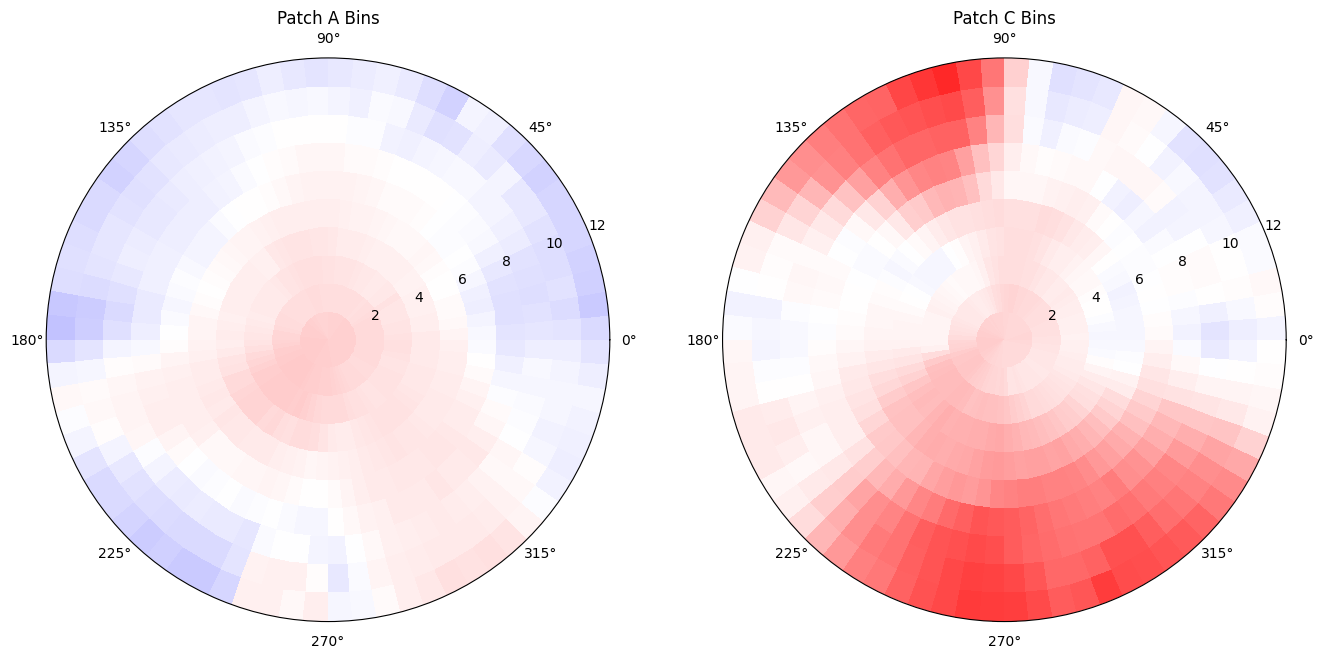

In [60]:
# Plot
fig, (ax1, ax2) = plt.subplots(ncols=2, subplot_kw=dict(projection='polar'), figsize=(16,8))

# Patch_A
col_A = tensor_A[:,:, feature] # Select the values of the feature chosen to display as color
ax1.pcolormesh(angular, radial, col_A, cmap = "bwr", norm=normalize_col_features)
ax1.set_title('Patch A Bins')
ax1.set_ylim([0, max_rho])
ax1.set_yticks([2.0, 4.0, 6.0, 8.0, 10.0, 12.0])
# Patch_C
col_C = tensor_C[:,:, feature] # Select the values of the feature chosen to display
ax2.pcolormesh(angular, radial, col_C, cmap = "bwr", norm=normalize_col_features)
ax2.set_title('Patch C Bins')
ax2.set_ylim([0, max_rho])
ax2.set_yticks([2.0, 4.0, 6.0, 8.0, 10.0, 12.0])
plt.show()

### Compare the two patches in all possible orientations

In [61]:
# Give two same-sized tensors, the second one will be rotated and compared with the first
best_score, best_rotation, best_tensor_C, best_dot_matrix = compare_patches(tensor_A, tensor_C, max_rho)

#os.chdir('c:\\Users\\david\\MT_code\\rotated_patches')
#np.save('tensor_C' + str(center_C) + '_rotated.npy', best_tensor_C)
#np.save('tensor_C' + str(center_C) + '_dotmatrix.npy', best_dot_matrix)

print("Best Score: " + str(int(best_score)) + " after " + str(best_rotation) + " rotations")

Best Score: 435 after 4 rotations


In [62]:
# Normalization of Features between -1 and 1 (whole features table) with centering of patches
'''
chain_C_patch_6820.npy     Best Score: 438 after 55 rotations

chain_C_patch_6509.npy     Best Score: 493 after 26 rotations
chain_C_patch_5237.npy     Best Score: 424 after 29 rotations
chain_C_patch_3200.npy     Best Score: 642 after 30 rotations
chain_C_patch_1888.npy     Best Score: 414 after 5 rotations
chain_C_patch_1291.npy     Best Score: 540 after 59 rotations
chain_C_patch_446.npy      Best Score: 355 after 46 rotations
'''

'\nchain_C_patch_6820.npy     Best Score: 438 after 55 rotations\n\nchain_C_patch_6509.npy     Best Score: 493 after 26 rotations\nchain_C_patch_5237.npy     Best Score: 424 after 29 rotations\nchain_C_patch_3200.npy     Best Score: 642 after 30 rotations\nchain_C_patch_1888.npy     Best Score: 414 after 5 rotations\nchain_C_patch_1291.npy     Best Score: 540 after 59 rotations\nchain_C_patch_446.npy      Best Score: 355 after 46 rotations\n'

In [63]:
# Compute complementarity per feature
complementarity_data = {}

for i in range(16):
    # Calculate the mean element-wise
    feature_comp = np.abs(np.add(tensor_A[:, :, i], best_tensor_C[:,:,i])/2)
    complementarity_data[i]=feature_comp

C:\Users\david\AppData\Local\Temp\ipykernel_8048\81095873.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.pcolormesh(angular, radial, col_A, cmap = "bwr", norm=normalize_col_features)
C:\Users\david\AppData\Local\Temp\ipykernel_8048\81095873.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.pcolormesh(angular, radial, col_Cr, cmap = "bwr", norm=normalize_col_features)
C:\Users\david\AppData\Local\Temp\ipykernel_8048\81095873.py:36: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.pcolormesh(angular, radial, col_comp, cmap = "Reds", norm=normalize_col_comp)


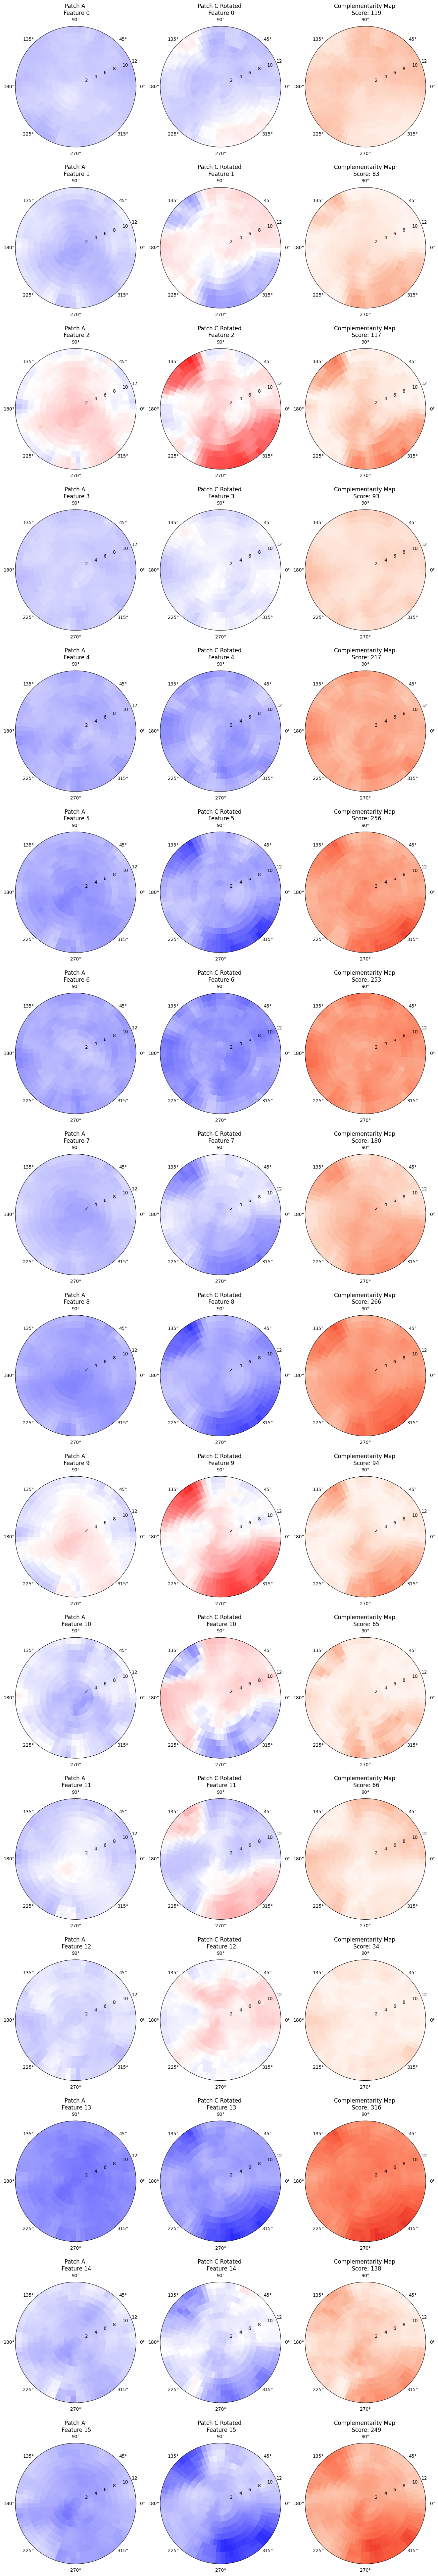

In [64]:
#  Plot

normalize_col_comp = colors.Normalize(vmin=0, vmax=1)

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12),
      (ax13, ax14, ax15), (ax16, ax17, ax18), (ax19, ax20, ax21), (ax22, ax23, ax24),
      (ax25, ax26, ax27), (ax28, ax29, ax30), (ax31, ax32, ax33), (ax34, ax35, ax36),
      (ax37, ax38, ax39), (ax40, ax41, ax42), (ax43, ax44, ax45), (ax46, ax47, ax48)) = plt.subplots(nrows=16, ncols=3 ,subplot_kw=dict(projection='polar'), figsize=(16,100))


for feature, i in enumerate([(ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12),
      (ax13, ax14, ax15), (ax16, ax17, ax18), (ax19, ax20, ax21), (ax22, ax23, ax24),
      (ax25, ax26, ax27), (ax28, ax29, ax30), (ax31, ax32, ax33), (ax34, ax35, ax36),
      (ax37, ax38, ax39), (ax40, ax41, ax42), (ax43, ax44, ax45), (ax46, ax47, ax48)]):
      
      ax = i[0] 

      # Patch A unrotated
      col_A = tensor_A[:,:, feature] # Select the values of the feature chosen to display as color
      ax.pcolormesh(angular, radial, col_A, cmap = "bwr", norm=normalize_col_features)
      ax.set_title('Patch A \n Feature '+str(feature))
      ax.set_ylim([0, max_rho])
      ax.set_yticks([2.0, 4.0, 6.0, 8.0, 10.0, 12.0])

      ax=i[1]
      # Patch C rotated
      col_Cr = best_tensor_C[:,:, feature] # Select the values of the feature chosen to display
      ax.pcolormesh(angular, radial, col_Cr, cmap = "bwr", norm=normalize_col_features)
      ax.set_title('Patch C Rotated \n Feature '+str(feature))
      ax.set_ylim([0, max_rho])
      ax.set_yticks([2.0, 4.0, 6.0, 8.0, 10.0, 12.0])

      ax=i[2]
      # Complementarity
      col_comp = complementarity_data[feature]
      ax.pcolormesh(angular, radial, col_comp, cmap = "Reds", norm=normalize_col_comp)
      ax.set_title('Complementarity Map \n Score: {score}'.format(score = int(np.sum(col_comp) )))
      ax.set_ylim([0, max_rho])
      ax.set_yticks([2.0, 4.0, 6.0, 8.0, 10.0, 12.0])

plt.show()


In [65]:
os.chdir('c:\\Users\\david\\MT_code\\rotated_patches')

patches = [6820, 6509, 5237, 3200, 1888, 1291, 446]
scores = [438, 493, 424, 642, 414, 540, 355]

complementarity_data = []

for patch in patches:
    ten_C = np.load('tensor_C{patch}_rotated.npy'.format(patch=patch), allow_pickle="TRUE")
    ten_A = tensor_A

    feature_complementarities = []
    for i in range(16):
        feature_comp = np.abs(np.add(ten_A[:, :, i], ten_C[:,:,i])/2)
        comp_value = np.sum(feature_comp)
        feature_complementarities.append(comp_value)

    complementarity_data.append(feature_complementarities)
    

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'c:\\Users\\david\\MT_code\\rotated_patches'

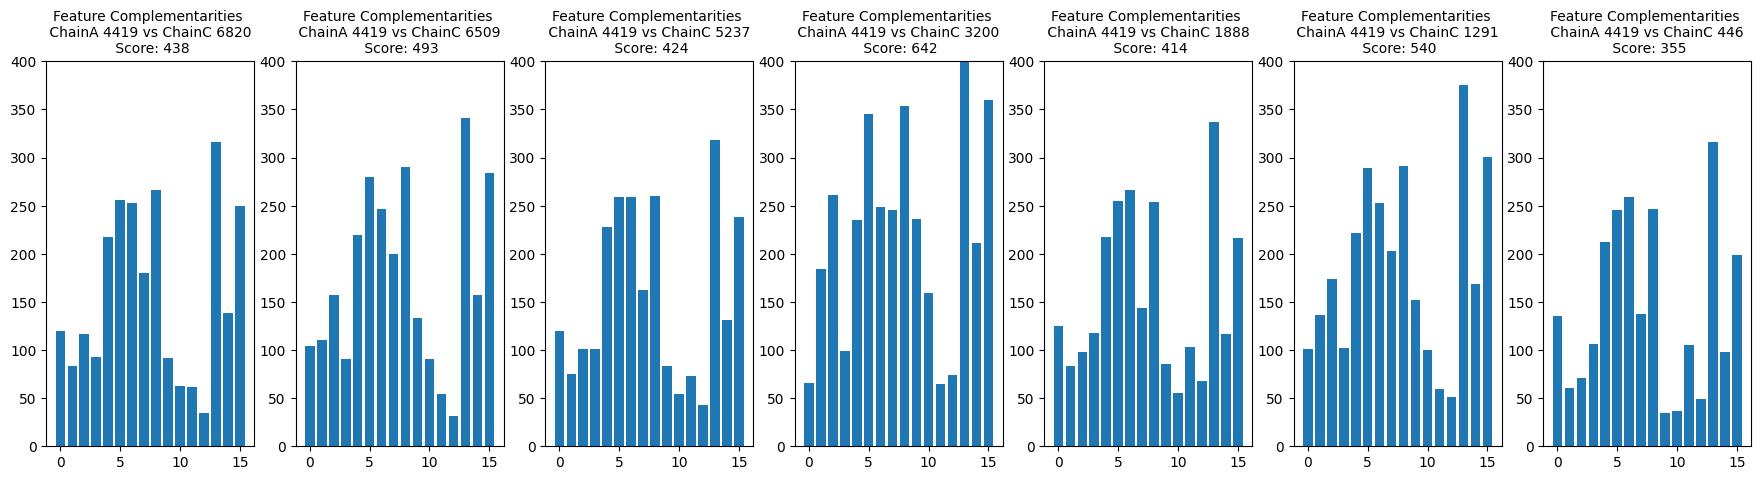

In [ ]:
fig, axs = plt.subplots(1, 7, figsize=(22,5))
axs[0].bar([f for f in range(16)], complementarity_data[0])
axs[0].set_title('Feature Complementarities \n ChainA 4419 vs ChainC {c} \n Score: {score}'.format(c=patches[0], score = scores[0]), fontsize = 10)

axs[1].bar([f for f in range(16)], complementarity_data[1])
axs[1].set_title('Feature Complementarities \n ChainA 4419 vs ChainC {c} \n Score: {score}'.format(c=patches[1], score = scores[1]), fontsize = 10)

axs[2].bar([f for f in range(16)], complementarity_data[2])
axs[2].set_title('Feature Complementarities \n ChainA 4419 vs ChainC {c} \n Score: {score}'.format(c=patches[2], score = scores[2]), fontsize = 10)

axs[3].bar([f for f in range(16)], complementarity_data[3])
axs[3].set_title('Feature Complementarities \n ChainA 4419 vs ChainC {c} \n Score: {score}'.format(c=patches[3], score = scores[3]), fontsize = 10)

axs[4].bar([f for f in range(16)], complementarity_data[4])
axs[4].set_title('Feature Complementarities \n ChainA 4419 vs ChainC {c} \n Score: {score}'.format(c=patches[4], score = scores[4]), fontsize = 10)

axs[5].bar([f for f in range(16)], complementarity_data[5])
axs[5].set_title('Feature Complementarities \n ChainA 4419 vs ChainC {c} \n Score: {score}'.format(c=patches[5], score = scores[5]), fontsize = 10)

axs[6].bar([f for f in range(16)], complementarity_data[6])
axs[6].set_title('Feature Complementarities \n ChainA 4419 vs ChainC {c} \n Score: {score}'.format(c=patches[6], score = scores[6]), fontsize = 10)

for ax in axs.flat:
    ax.set_ylim([0, 400])


In [ ]:
#Without Normalization of Features
'''
chain_C_patch_6820.npy     Best Score: 7014 after 55 rotations

chain_C_patch_6509.npy     Best Score: 9002 after 28 rotations
chain_C_patch_5237.npy     Best Score: 6709 after 32 rotations
chain_C_patch_3200.npy     Best Score: 12103 after 29 rotations
chain_C_patch_1888.npy     Best Score: 6266 after 7 rotations
chain_C_patch_1291.npy     Best Score: 9530 after 60 rotations
chain_C_patch_446.npy      Best Score: 4830 after 66 rotations
'''

'''
Normalization of Features between -1 and 1 (column-wise). This does not work, it "falsifies" the results

chain_C_patch_6820.npy     Best Score: 184 after 55 rotations

chain_C_patch_6509.npy     Best Score: 202 after 28 rotations
chain_C_patch_5237.npy     Best Score: 301 after 32 rotations
chain_C_patch_3200.npy     Best Score: 35 after 14 rotations
chain_C_patch_1888.npy     Best Score: 359 after 7 rotations
chain_C_patch_1291.npy     Best Score: 205 after 60 rotations
chain_C_patch_446.npy      Best Score: 345 after 66 rotations
'''
'''
Normalization of Features between 0 and 1 (column-wise) This does not work, it "falsifies" the results

chain_C_patch_6820.npy     Best Score: 2116 after 55 rotations

chain_C_patch_6509.npy     Best Score: 2085 after 28 rotations
chain_C_patch_5237.npy     Best Score: 2155 after 32 rotations
chain_C_patch_3200.npy     Best Score: 1871 after 14 rotations
chain_C_patch_1888.npy     Best Score: 2114 after 7 rotations
chain_C_patch_1291.npy     Best Score: 1900 after 60 rotations
chain_C_patch_446.npy      Best Score: 2100 after 66 rotations
'''

'\nNormalization of Features between 0 and 1 (column-wise) This does not work, it "falsifies" the results\n\nchain_C_patch_6820.npy     Best Score: 2116 after 55 rotations\n\nchain_C_patch_6509.npy     Best Score: 2085 after 28 rotations\nchain_C_patch_5237.npy     Best Score: 2155 after 32 rotations\nchain_C_patch_3200.npy     Best Score: 1871 after 14 rotations\nchain_C_patch_1888.npy     Best Score: 2114 after 7 rotations\nchain_C_patch_1291.npy     Best Score: 1900 after 60 rotations\nchain_C_patch_446.npy      Best Score: 2100 after 66 rotations\n'